In [1]:
import numpy as np
from obspy import read
from obspy.io.xseed import Parser
from scipy import signal
import obspy
import matplotlib.pyplot as plt

## Loading Data and decimate it to 25Hz by factor 2

In [2]:
st = read('../TEST_DATA/DATA/KNR01/BHZ.D/1B.KNR01..BHZ.D.2016.337')
st = st.decimate(factor=2)

# Filtercorner testing

In [ ]:
st_filt = st.copy()
st_filt = st_filt.filter('bandpass',freqmin=1, freqmax=8)
st_array = np.asarray(st[0].data)
st_filt_array = np.asarray(st_filt[0].data)

fs = int(st_filt[0].stats.sampling_rate)

t_start = fs*20000
t1_start = t_start+fs*8000
st_nofilt_10_min = st_array[t_start:t_start+10*fs*60]
st_filt_10_min = st_filt_array[t_start:t_start+10*fs*60]
#test1_10_min = st_array[t1_start:t1_start+10*fs*60]

In [ ]:
f, Pxx = signal.periodogram(st_nofilt_10_min, fs=fs)
f1,Pxx1 = signal.periodogram(st_filt_10_min, fs=fs)

In [ ]:
#plt.semilogy(f, Pxx)
plt.subplot(121)
plt.plot(f, Pxx,label='nofilt')
#plt.xlim(0,5)
#plt.ylim(1e-4,1e6)
plt.grid()

plt.subplot(122)
plt.plot(f1, Pxx1,label='filt')
#plt.xlim(0,1)
#plt.ylim(1e-4,1e6)
plt.grid()

plt.show()

# Remove response

In [ ]:
parser01 = Parser('../TEST_DATA/Resp/RESP.1B.KNR01..BHZ')
st_simu = st.copy()
st_simu.simulate(seedresp={'filename': parser01, 'units': "ACC"})

In [ ]:
st_simu_filt = st_simu.copy()
st_simu_array = np.array(st_simu[0].data)

st_simu_filt = st_simu_filt.filter('highpass',freq=1)
st_simu_filt_array = np.array(st_simu_filt[0].data)

In [ ]:
plt.plot(st_simu_filt_array)
#plt.xlim(318800,319500)
plt.show()

In [ ]:
t_start = fs*20000
t1_start = t_start+fs*30000

st_simu_nofilt_10_min = st_simu_array[t_start:t_start+10*fs*60]
st_simu_filt_10_min = st_simu_filt_array[t_start:t_start+10*fs*60]

In [ ]:
f2, Pxx2 = signal.periodogram(st_simu_nofilt_10_min, fs=fs)
f3, Pxx3 = signal.periodogram(st_simu_filt_10_min, fs=fs)

In [ ]:
plt.figure(figsize=(11,11))
#plt.semilogy(f, Pxx)
plt.subplot(221)
plt.plot(f, Pxx,label='nofilt')
#plt.xlim(0,5)
#plt.ylim(1e-4,1e6)
plt.legend()
plt.grid()

plt.subplot(222)
plt.plot(f1, Pxx1,label='filt')
#plt.xlim(0,1)
#plt.ylim(1e-4,1e6)
plt.legend()
plt.grid()

#plt.semilogy(f, Pxx)
plt.subplot(223)
plt.plot(f2, Pxx2, label='st_simu_nofilt')
#plt.xlim(0,1)
#plt.ylim(1e-4,1e6)
plt.legend()
plt.grid()

plt.subplot(224)
plt.plot(f3, Pxx3, label='st_simu_filt')
#plt.xlim(0,1)
#plt.ylim(1e-4,1e6)
plt.legend()
plt.grid()

plt.show()

# Signal vs. no signal

In [3]:
parser01 = Parser('../TEST_DATA/Resp/RESP.1B.KNR01..BHZ')
st_simu = st.copy()
st_simu.simulate(seedresp={'filename': parser01, 'units': "ACC"})

/home/david/anaconda3/envs/vgseis_2018/lib/python3.6/site-packages/obspy/signal/detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):


1 Trace(s) in Stream:
1B.KNR01..BHZ | 2016-12-02T00:00:00.000000Z - 2016-12-02T23:59:59.920000Z | 25.0 Hz, 2159999 samples

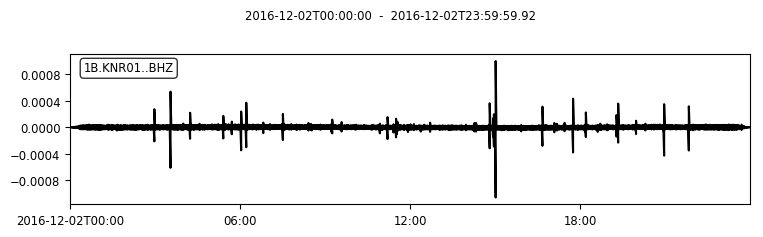

In [4]:
st_simu.plot()

In [22]:
st_simu_filt = st_simu.copy()
st_simu_filt = st_simu_filt.filter('bandpass',freqmin=1, freqmax=6.9)

In [55]:
fs = int(st_simu[0].stats.sampling_rate)
print(fs)
t_signal_start = 30000*fs
t_nosignal_start = 38000*fs
win_len = 4*60*fs

st_simu_array = np.array(st_simu_filt[0].data)

25


In [56]:
st_simu_signal_1_min = st_simu_array[t_signal_start:t_signal_start+win_len]
f_sig, Pxx_sig = signal.periodogram(st_simu_signal_1_min, fs=fs)

In [57]:
for i in range()

SyntaxError: invalid syntax (<ipython-input-57-f8d1be0104ca>, line 1)

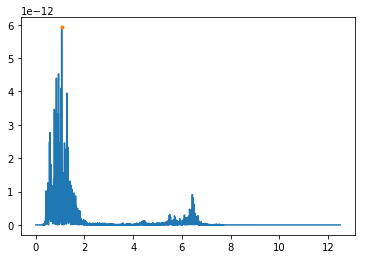

In [58]:
plt.plot(f_sig, Pxx_sig)
plt.plot(f_sig[np.argmax(Pxx_sig)], np.max(Pxx_sig), '.')
#plt.plot(f_sig[np.argmax(Pxx_sig[::1])], np.max(Pxx_sig[::1]), 'o')
plt.show()

In [59]:
def searchmaxima(maxima, data, fs=fs):
    
    '''Function to cut daily data into several windows and searches for maxima in window
    Input:
    
    maxima    float        number of maxima to search for
    signal    array        array with data
    fs        float        value of sampling rate
    wlen      int          value of window length in seconds
    
    '''

    f_sig, Pxx_sig = signal.periodogram(data, fs=fs)
    index_max = np.zeros(maxima)
    value_max_f = np.zeros(maxima)
    value_max = np.zeros(maxima)
    Pxx_sig1 = Pxx_sig.copy()
    
    #wlen = wlen * fs
    #st_simu_signal_1_min = st_simu_array[t_signal_start:t_signal_start+win_len]
    #for wlen in data:
        #data_cut = st_simu_array[t_signal_start:t_signal_start+win_len]
        #print(data_cut)
    for i in range(maxima):

        # first maxima

        index_max[i] = np.argmax(Pxx_sig1)
        value_max_f[i] = f_sig[np.argmax(Pxx_sig1)]
        value_max[i] = np.max(Pxx_sig1)


        Pxx_sig1[int(index_max[i]-10):int(index_max[i]+10)] = 0
    #fname = '../Plots/PSD/KNR01..BHZ.D.2016.337' + str(t_signal_start) + '-' + str(t_signal_start+ win_len)
    #plt.semilogy(f_sig, Pxx_sig)
    #plt.semilogy(value_max_f, value_max, 'o')
    #plt.plot(value_ond_max_f, value_second_max, 'o')
    #plt.plot(value_third_max_f, value_third_max, 'o')
    #plt.plot(value_fourth_max_f, value_fourth_max, 'o')
    #plt.plot(f_sig[np.argmax(Pxx_sig[::1])], np.max(Pxx_sig[::1]), 'o')
    #plt.savefig(fname=fname)
    return(value_max_f, value_max)

In [60]:
maxima = 8
data= st_simu_signal_1_min

value_max_f, value_max = searchmaxima(maxima, data, fs=fs)

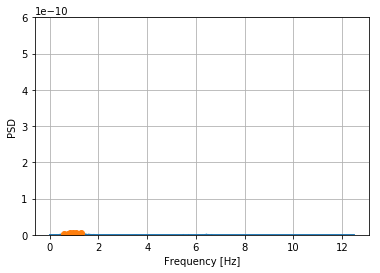

In [61]:
plt.plot(f_sig, Pxx_sig)
plt.plot(value_max_f, value_max, 'o')
plt.ylim(0*1e-10,6*1e-10)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
#plt.xlim(1.2,2)
plt.grid()
#plt.plot(value_ond_max_f, value_second_max, 'o')
#plt.plot(value_third_max_f, value_third_max, 'o')
#plt.plot(value_fourth_max_f, value_fourth_max, 'o')
#plt.plot(f_sig[np.argmax(Pxx_sig[::1])], np.max(Pxx_sig[::1]), 'o')
plt.show()



# next steps...
# 1) while schleife mit abbruchkriterium nach 4-6 Durchlaeufen
# 2) als definition schreiben
# 3) 

In [ ]:
print(np.mean(Pxx_sig)*100)
b = Pxx_sig > np.mean(Pxx_sig)*100


In [19]:
24*60*60

86400

In [ ]:
print(len(Pxx_sig))
print(len(Pxx_sig[::-1]))


plt.plot(Pxx_sig)
plt.plot(Pxx_sig[::-1], '.')
plt.show()

In [ ]:
#k = 0
#for i in range((t_signal_start),int(t_signal_start+(t_nosignal_start-t_signal_start)), int(win_len)):
    #print(i/fs)
    #k += 1
#print(k)
#print(fs)

#for i in arange(int(t_signal_start),int(t_signal_start+(t_nosignal_start-t_signal_start)), int(win_len)):
#    print(i)

In [ ]:
for i in range(int(t_signal_start),int(t_nosignal_start), int(win_len)):
    print(i/fs,(i+win_len)/fs)
    st_simu_signal_1_min = st_simu_array[i:i+win_len]
    f_sig, Pxx_sig = signal.periodogram(st_simu_signal_1_min, fs=fs)
    plt.plot(f_sig, Pxx_sig, label=i/fs)
    #plt.ylim(10e-18,.8*10e-10)
    plt.ylim(0,.03*10e-10)
    plt.legend()
    plt.grid()
    #print(str(t_signal_start/fs + i/fs))
    plt.savefig('../Plots/Amplitude_SPEC/Lin/' + str(i/fs) + 'lin' + '.png')
    plt.clf()
#plt.show()
#st_simu_signal_10more_min = st_simu_array[t_singal_start+5*fs*60:t_singal_start+20*fs*60]
#st_simu_signal_10less_min = st_simu_array[t_singal_start-5*fs*60:t_singal_start]

#st_simu_nosignal_10_min = st_simu_array[t_nosingal_start:t_nosingal_start+10*fs*60]

In [ ]:
f_sig, Pxx_sig = signal.periodogram(st_simu_signal_1_min, fs=fs)
#f_sig1, Pxx_sig1 = signal.periodogram(st_simu_signal_10more_min, fs=fs)
#f_sig2, Pxx_sig2 = signal.periodogram(st_simu_signal_10less_min, fs=fs)

In [ ]:
plt.figure(figsize=(8,8))

#plt.subplot(131)
plt.plot(f_sig, Pxx_sig,label='3min')
#plt.xlim(0,1)
plt.ylim(0,.8*1e-9)
plt.grid()
plt.legend()
plt.show()

In [ ]:
plt.subplot(132)
plt.plot(f_sig, Pxx_sig,label='signal')
#plt.xlim(0,5)
plt.ylim(0,.8*1e-9)
plt.grid()

plt.subplot(133)
plt.plot(f_sig1, Pxx_sig1,label='10min more')
#plt.xlim(0,1)
plt.ylim(0,.8*1e-9)
plt.grid()



plt.show()

In [20]:
86400/(4*60)

360.0

In [ ]:
st_simu.plot()

In [ ]:
3600*24

In [ ]:
2159999/86400

In [ ]:
for i in range(0,(t_nosingal_start-t_singal_start), win_len):
    print(i)

In [ ]:
4*60